# GaitRehab Explanatory Data Analysis

### Sensor Placement Breakdown & Expected Insights

1. **Left and Right Foot**
    - Importance:
        - Critical for detecting initial contact (heel strike) and toe-off.
        - Captures the start and end of stance and swing phases precisely.

        What we can extract: 
        - Stride length, stride time, cadence.
        - Foot flat, toe-off, and heel-strike events.
        - Step asymmetry.
        - Angular velocity in z-axis helps detect gait events (peaks and zero crossings).

2. **Left and Right Shank (Lower leg)**
    - Importance:
        - Key in modeling the swing phase and knee flexion/extension.
        - Angular velocity signals are rich for stride and gait cycle events.

        What we can extract:
        - Swing dynamics, peak angular velocities during swing.
        - Stance/swing time via gyroscope events (zero crossings, minima).
        - Compare left and right sides for asymmetry detection.
        - Optionally estimate step length or velocity via integration of acceleration.

3. **Left and Right Thigh**
    - Importance:
        - Helps understand hip motion, limb coordination, and interlimb timing.
        - Valuable for post-stroke patients with abnormal hip/knee control.
        
        What we can extract:
        - Hip extension/flexion timing.
        - Detect compensatory strategies like circumduction or hip hiking.
        - Estimate range of motion at the hip joint (with joint angle inference).

4. **Lower Back (Sacrum/Lumbar area)**
    - Importance:
        - Represents center of mass (CoM) movement.
        - Useful for balance, postural stability, and overall gait rhythm.
        
        What we can extract:
        - Symmetry of trunk motion.
        - Trunk sway in medio-lateral direction (important in stroke).
        - Vertical displacement and rhythm of walking.
        - Step count and cadence from vertical acceleration peaks.


### Why Multiple Sensors Matter (especially for stroke rehab)
| Sensor Location |	Clinical Relevance Typical Use                              |
|-----------------|-------------------------------------------------------------|
| Feet            | Foot contact timing, stance/swing phase	Gait cycle events   |
| Shank	          | Timing of swing, stride time Asymmetry, stride duration     |
| Thigh	          | Compensatory motion, coordination	Detect abnormal hip use |
| Lower           | Back Trunk balance, rhythm Stability, fall risk             |


### Suggested Signal Use

|Signal Type	  | Useful Axes	Application                                                                              |
|-----------------|------------------------------------------------------------------------------------------------------|
|Gyroscope	      | Z (rotation around vertical), Y (rotation around frontal plane)	Angular events: heel strike, toe-off |
|Accelerometer	  | Vertical (Z), AP (X), ML (Y) Step detection, trunk sway, CoM estimation                              |

---

In [1]:
# Libraries
import os, sys, math, random, time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks

# Display settings
plt.rcParams['figure.figsize'] = (15, 5)

# Constants
data_path = "/Users/stamatiosorphanos/Documents/GaitRehab_Models/data"
healthy_directory = os.path.join(data_path, "Healthy")
stroke_directory  = os.path.join(data_path, "Stroke")

# Translation dictionary
positions_dict = {}

# Inertial Measurement Unit - IMU EDA

**IMU Accelerometer Data**: provides us a body motion information (e.g., trunk or limb acceleration) over time, which is
useful for detecting gait events like heel strikes, toe-offs, stride time, and cadence.



| Axis	| Typical Meaning (depends on IMU orientation)          |
|-------|-------------------------------------------------------|
| X-axis| Forward-backward motion (anteroposterior)             |
| Y-axis| Side-to-side motion (mediolateral)                    |
| Z-axis| Up-down motion (vertical) — used most for gait events |




**IMU Gyroscope Data**: provides angular velocity of body segments like limb rotations. It is especially useful for identifying gait phase transitions, such as detecting swing vs. stance, and for estimating stride cycles, cadence, and smoothness of movement.

- During swing, angular velocity increases (due to leg rotation).
- During stance, angular velocity is close to zero (foot stable on ground).
- Peaks in gyroscope signals often correspond to maximum limb swing or mid-swing.

|Axis   | Typical Meaning (depends on IMU orientation)            |
|-------|---------------------------------------------------------|
|X-axis | Rotation around the anteroposterior axis (e.g., roll)   |
|Y-axis | Rotation around the mediolateral axis (e.g., pitch)     |
|Z-axis | Rotation around the vertical axis (e.g., yaw, leg swing)|


In [2]:
imu_df_accelerometer = pd.read_csv("data/Healthy/Patient_1/IMU/3D-2022-01-19T10.53.38.171-F0794D73E83D-Accelerometer.csv")
imu_df_accelerometer[['x-axis (g)', 'y-axis (g)', 'z-axis (g)']] /= 1000.0
imu_df_accelerometer['time (s)'] = imu_df_accelerometer['elapsed (s)'] / 1000.0
imu_df_accelerometer.head()

,epoc (ms),timestamp (+0700),elapsed (s),x-axis (g),y-axis (g),z-axis (g),time (s)
0,1642564423045,2022-01-19T10.53.43.045,0.00,0.000948,0.000057,-0.000152,0.00000
1,1642564423055,2022-01-19T10.53.43.055,0.01,0.000957,0.000060,-0.000157,0.00001
2,1642564423065,2022-01-19T10.53.43.065,0.02,0.000951,0.000063,-0.000162,0.00002
3,1642564423075,2022-01-19T10.53.43.075,0.03,0.000950,0.000064,-0.000163,0.00003
4,1642564423085,2022-01-19T10.53.43.085,0.04,0.000952,0.000063,-0.000160,0.00004


In [3]:
imu_df_gyroscope = pd.read_csv("data/Healthy/Patient_1/IMU/3D-2022-01-19T10.53.38.171-F0794D73E83D-Gyroscope.csv")
imu_df_gyroscope[['x-axis (deg/s)', 'y-axis (deg/s)', 'z-axis (deg/s)']] /= 1000.0
imu_df_gyroscope['time (s)'] = imu_df_gyroscope['elapsed (s)'] / 1000.0
imu_df_gyroscope.head()

,epoc (ms),timestamp (+0700),elapsed (s),x-axis (deg/s),y-axis (deg/s),z-axis (deg/s),time (s)
0,1642564423046,2022-01-19T10.53.43.046,0.00,-0.002561,-0.002378,-0.005427,0.00000
1,1642564423056,2022-01-19T10.53.43.056,0.01,-0.002439,-0.002195,-0.005610,0.00001
2,1642564423066,2022-01-19T10.53.43.066,0.02,-0.001768,-0.002378,-0.005671,0.00002
3,1642564423076,2022-01-19T10.53.43.076,0.03,0.000183,-0.002378,-0.005915,0.00003
4,1642564423086,2022-01-19T10.53.43.086,0.04,0.002134,-0.002866,-0.005915,0.00004


---

## Plot Raw IMU Accelerometer Signals

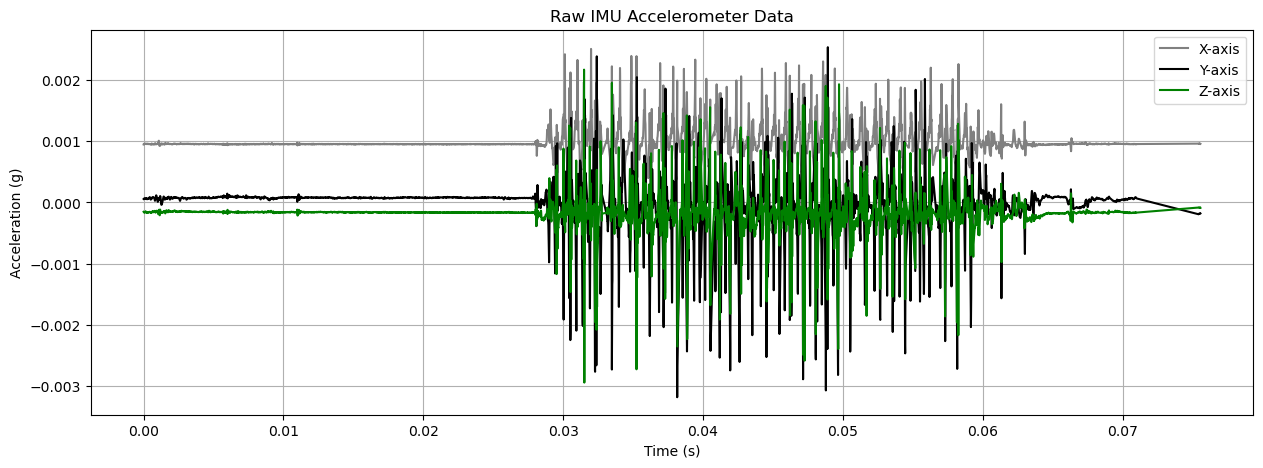

In [4]:
plt.plot(imu_df_accelerometer['time (s)'], imu_df_accelerometer['x-axis (g)'], label='X-axis', color='grey')
plt.plot(imu_df_accelerometer['time (s)'], imu_df_accelerometer['y-axis (g)'], label='Y-axis', color='black')
plt.plot(imu_df_accelerometer['time (s)'], imu_df_accelerometer['z-axis (g)'], label='Z-axis', color='green')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.title("Raw IMU Accelerometer Data")
plt.legend()
plt.grid(True)
plt.show()


## Plot Raw IMU Gyroscope Signals

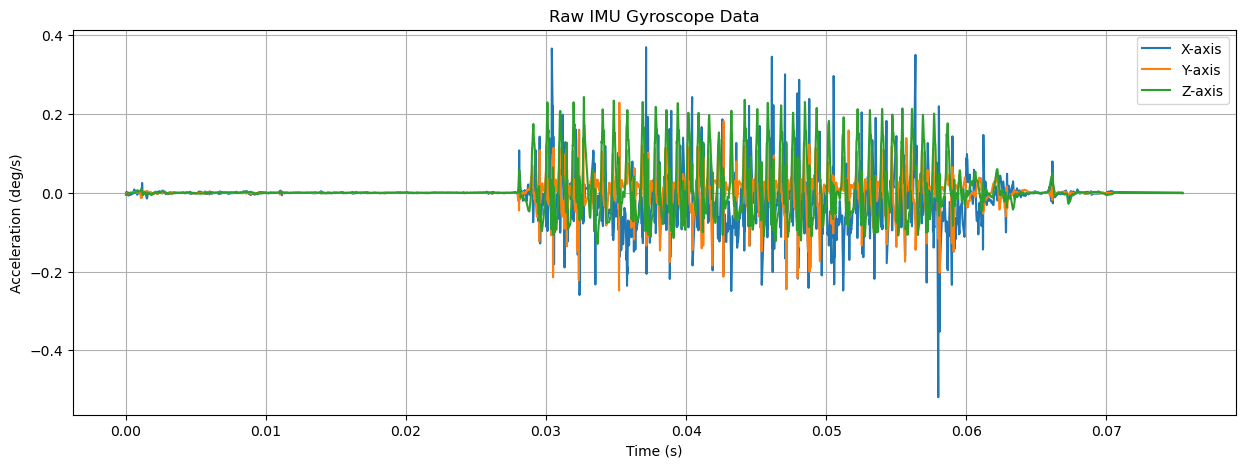

In [5]:
plt.plot(imu_df_gyroscope['time (s)'], imu_df_gyroscope['x-axis (deg/s)'], label='X-axis')
plt.plot(imu_df_gyroscope['time (s)'], imu_df_gyroscope['y-axis (deg/s)'], label='Y-axis')
plt.plot(imu_df_gyroscope['time (s)'], imu_df_gyroscope['z-axis (deg/s)'], label='Z-axis')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (deg/s)")
plt.title("Raw IMU Gyroscope Data")
plt.legend()
plt.grid(True)
plt.show()

---

## Sensor Strengths

- **Accelerometer**: Detects impacts (heel strike), motion intensity, step timing
- **Gyroscope**    :  Detects rotations, phase changes (stance/swing), stride shape

Using both gives us a richer picture of gait dynamics and enables more robust detection in noisy or real-world environments.

### Z-Axis (Vertical)

Heel strikes and toe-offs generate impacts → clear peaks in vertical acceleration.
Most commonly used for detecting:
1.Stride time
2.Gait cycles
3.Heel strike timing
Ideal for step counting, cadence, and stride detection.

### X-Axis (Forward-Backward)
Captures propulsive motion.
Useful for:
1.Estimating walking speed
2.Detecting abnormalities in limb swing
3.Calculating gait symmetry (especially if comparing both legs)


### Y-Axis (Side-to-Side)
Sensitive to mediolateral sway or balance.
Often used to assess:
1. Postural stability
2. Fall risk
3. Lateral asymmetry (which is common in stroke or Parkinsonian gait)

---

### Low-Pass Filter for IMU

Why should we use a low pass filter

In [6]:
def butter_lowpass_filter(data, cutoff, fs=100, order=2):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

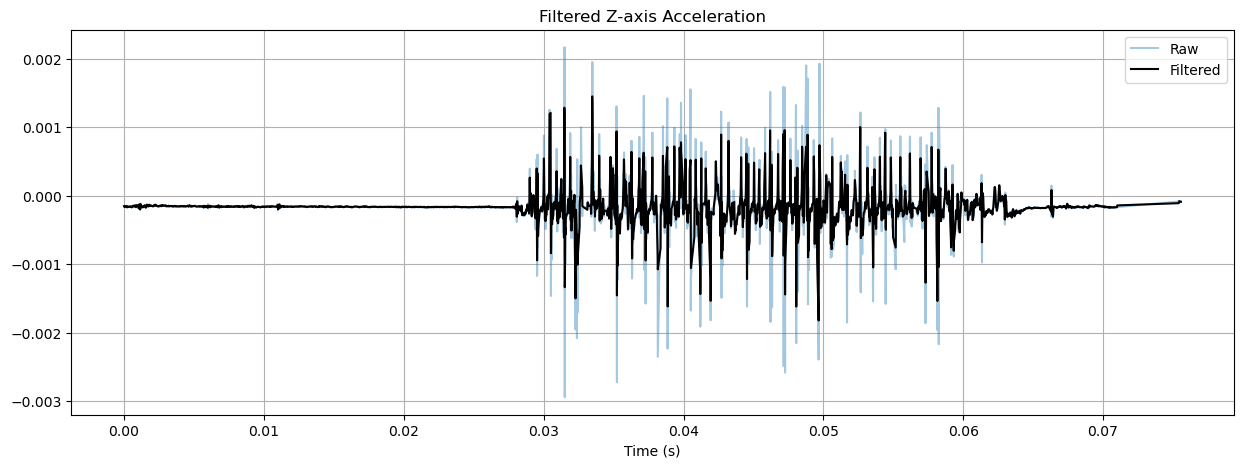

In [7]:
imu_df_accelerometer['z-filtered'] = butter_lowpass_filter(imu_df_accelerometer['z-axis (g)'], cutoff=20)

plt.plot(imu_df_accelerometer['time (s)'], imu_df_accelerometer['z-axis (g)'], alpha=0.4, label='Raw')
plt.plot(imu_df_accelerometer['time (s)'], imu_df_accelerometer['z-filtered'], label='Filtered', color='black')
plt.title('Filtered Z-axis Acceleration')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()


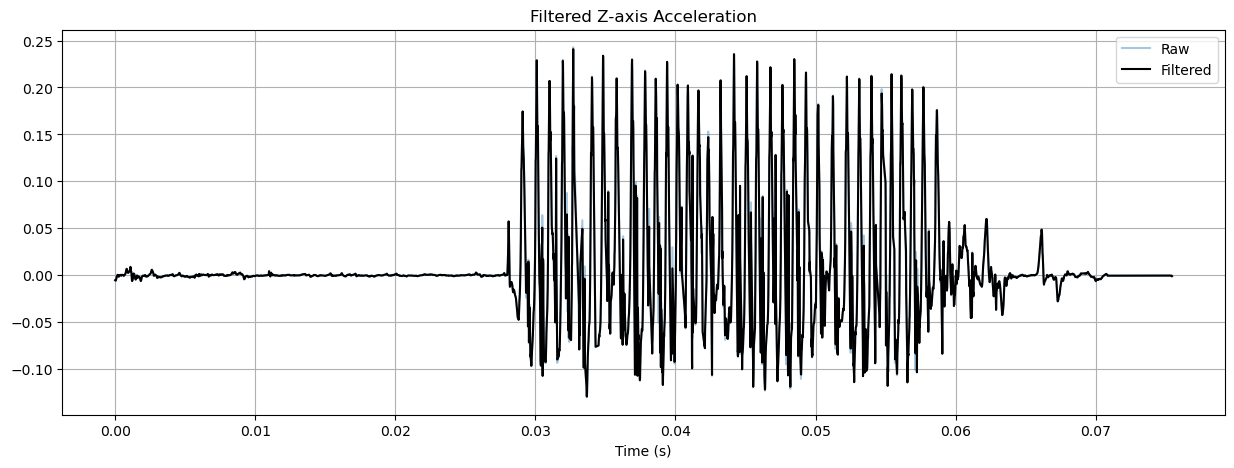

In [8]:
imu_df_gyroscope['z-filtered'] = butter_lowpass_filter(imu_df_gyroscope['z-axis (deg/s)'], cutoff=35)

plt.plot(imu_df_gyroscope['time (s)'], imu_df_gyroscope['z-axis (deg/s)'], alpha=0.4, label='Raw')
plt.plot(imu_df_gyroscope['time (s)'], imu_df_gyroscope['z-filtered'], label='Filtered', color='black')
plt.title('Filtered Z-axis Acceleration')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)
plt.show()

---

### Z-axis Peak Detection

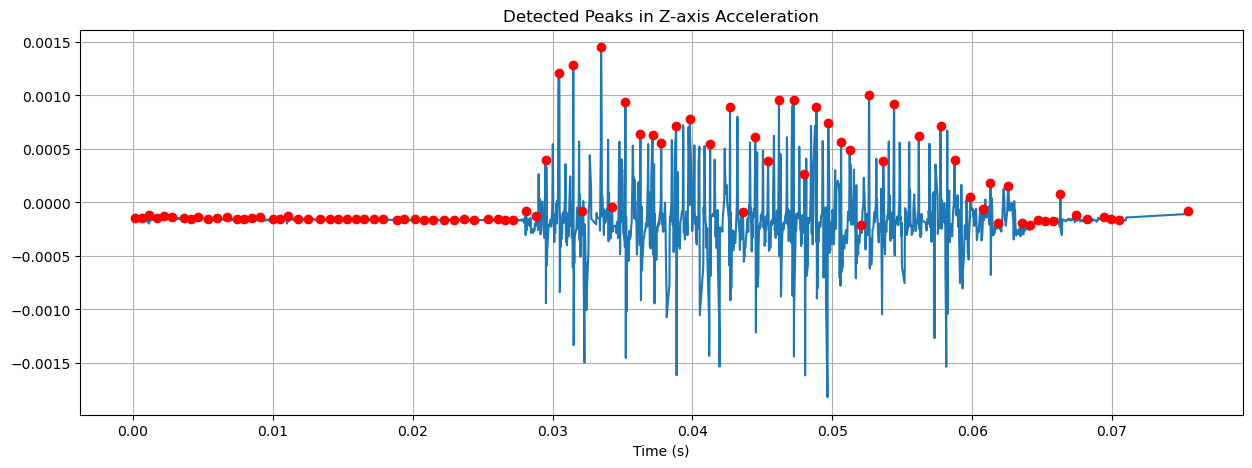

In [9]:
# Example: Detect peaks in filtered z-axis for heel strikes
peaks, _ = find_peaks(imu_df_accelerometer['z-filtered'], distance=50)

# Visualize detected peaks
plt.plot(imu_df_accelerometer['time (s)'], imu_df_accelerometer['z-filtered'])
plt.plot(imu_df_accelerometer['time (s)'].iloc[peaks], imu_df_accelerometer['z-filtered'].iloc[peaks], 'ro')
plt.title("Detected Peaks in Z-axis Acceleration")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

# Calculate stride time
stride_intervals = np.diff(imu_df_accelerometer['time (s)'].iloc[peaks])


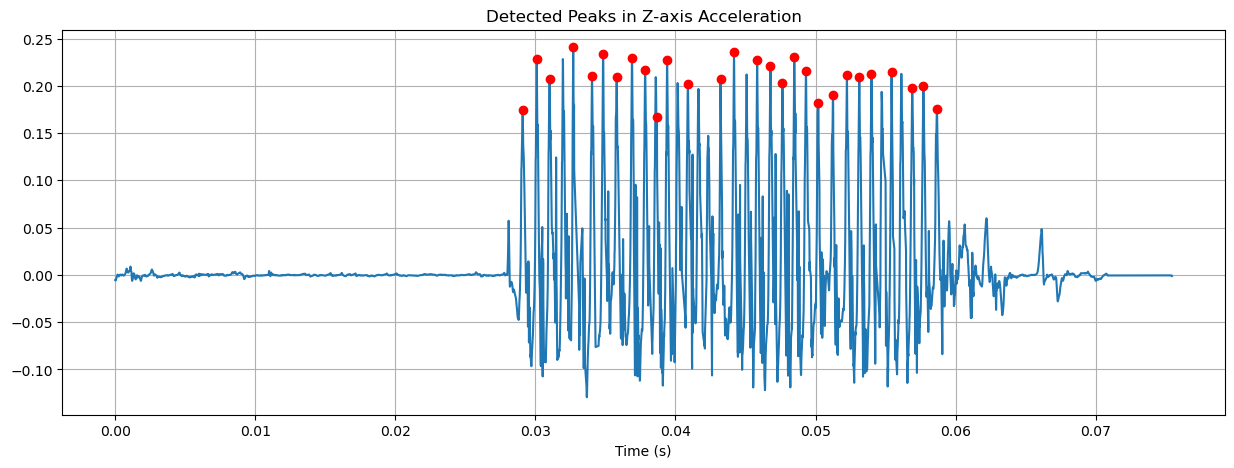

In [17]:
# Example: Detect peaks in filtered z-axis for heel strikes
peaks, _ = find_peaks(imu_df_gyroscope['z-filtered'], height=0.15, distance=50)

# Visualize detected peaks
plt.plot(imu_df_gyroscope['time (s)'], imu_df_gyroscope['z-filtered'])
plt.plot(imu_df_gyroscope['time (s)'].iloc[peaks], imu_df_gyroscope['z-filtered'].iloc[peaks], 'ro')
plt.title("Detected Peaks in Z-axis Acceleration")
plt.xlabel("Time (s)")
plt.grid(True)
plt.show()

# Calculate stride time
stride_intervals = np.diff(imu_df_gyroscope['time (s)'].iloc[peaks])

--- 

In [11]:
stride_intervals = np.diff(imu_df_accelerometer['time (s)'].iloc[peaks])
avg_stride_time = np.mean(stride_intervals)
cadence = 60 / avg_stride_time

print(f'Average Stride Time: {avg_stride_time:.6f} s')
print(f'Cadence: {cadence:.2f} steps/min')

imu_df_accelerometer.head()

Average Stride Time: 0.000816 s
Cadence: 73514.75 steps/min


,epoc (ms),timestamp (+0700),elapsed (s),x-axis (g),y-axis (g),z-axis (g),time (s),z-filtered
0,1642564423045,2022-01-19T10.53.43.045,0.00,0.000948,0.000057,-0.000152,0.00000,-0.000152
1,1642564423055,2022-01-19T10.53.43.055,0.01,0.000957,0.000060,-0.000157,0.00001,-0.000158
2,1642564423065,2022-01-19T10.53.43.065,0.02,0.000951,0.000063,-0.000162,0.00002,-0.000161
3,1642564423075,2022-01-19T10.53.43.075,0.03,0.000950,0.000064,-0.000163,0.00003,-0.000162
4,1642564423085,2022-01-19T10.53.43.085,0.04,0.000952,0.000063,-0.000160,0.00004,-0.000160


In [12]:
stride_intervals = np.diff(imu_df_gyroscope['time (s)'].iloc[peaks])
avg_stride_time = np.mean(stride_intervals)
cadence = 60 / avg_stride_time

print(f'Average Stride Time: {avg_stride_time:.6f} s')
print(f'Cadence: {cadence:.2f} steps/min')

imu_df_gyroscope.head()

Average Stride Time: 0.000817 s
Cadence: 73431.05 steps/min


,epoc (ms),timestamp (+0700),elapsed (s),x-axis (deg/s),y-axis (deg/s),z-axis (deg/s),time (s),z-filtered
0,1642564423046,2022-01-19T10.53.43.046,0.00,-0.002561,-0.002378,-0.005427,0.00000,-0.005427
1,1642564423056,2022-01-19T10.53.43.056,0.01,-0.002439,-0.002195,-0.005610,0.00001,-0.005586
2,1642564423066,2022-01-19T10.53.43.066,0.02,-0.001768,-0.002378,-0.005671,0.00002,-0.005704
3,1642564423076,2022-01-19T10.53.43.076,0.03,0.000183,-0.002378,-0.005915,0.00003,-0.005892
4,1642564423086,2022-01-19T10.53.43.086,0.04,0.002134,-0.002866,-0.005915,0.00004,-0.005928


---

# How to Detect Stance vs. Swing Using IMU Data

## General Principles:

1. **Stance phase**: The foot (or body segment) is in contact with the ground. There’s usually less movement and low acceleration.
2. **Swing phase** : The limb is moving through the air. You’ll typically see higher acceleration or dynamic patterns.

### Using Acceleration Magnitude + Thresholds

Compute:
$a_{mag} = \sqrt{x^2 + y^2 + z^2}$.

-> When acceleration is stable and low, it likely indicates stance.

-> When acceleration fluctuates and increases, it likely indicates swing.

In [13]:
# Compute acceleration magnitude
imu_df_accelerometer['a_mag'] = np.sqrt(
    imu_df_accelerometer['x-axis (g)']**2 + imu_df_accelerometer['y-axis (g)']**2 + imu_df_accelerometer['z-axis (g)']**2
)

# Threshold for swing vs stance
imu_df_accelerometer['phase'] = np.where(imu_df_accelerometer['a_mag'] > 0.001, 'swing', 'stance')


imu_df_accelerometer.head()

,epoc (ms),timestamp (+0700),elapsed (s),x-axis (g),y-axis (g),z-axis (g),time (s),z-filtered,a_mag,phase
0,1642564423045,2022-01-19T10.53.43.045,0.00,0.000948,0.000057,-0.000152,0.00000,-0.000152,0.000962,stance
1,1642564423055,2022-01-19T10.53.43.055,0.01,0.000957,0.000060,-0.000157,0.00001,-0.000158,0.000972,stance
2,1642564423065,2022-01-19T10.53.43.065,0.02,0.000951,0.000063,-0.000162,0.00002,-0.000161,0.000967,stance
3,1642564423075,2022-01-19T10.53.43.075,0.03,0.000950,0.000064,-0.000163,0.00003,-0.000162,0.000966,stance
4,1642564423085,2022-01-19T10.53.43.085,0.04,0.000952,0.000063,-0.000160,0.00004,-0.000160,0.000967,stance


In [14]:
counts = imu_df_accelerometer['phase'].value_counts()
counts

phase
stance    4527
swing     1703
Name: count, dtype: int64

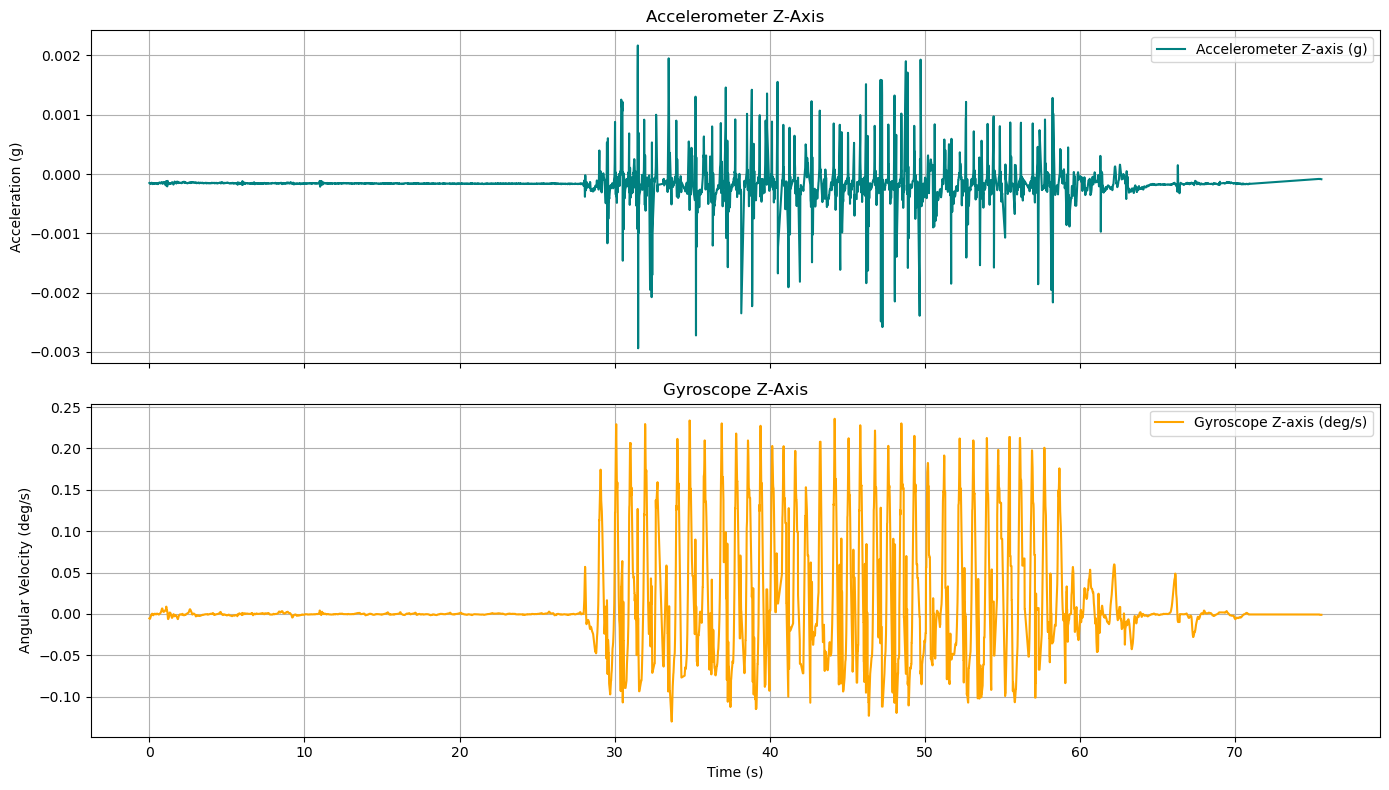

In [15]:
# Merge both datasets on the closest 'epoc (ms)' using an asof merge
# Sort first to enable merge_asof
accel_df = imu_df_accelerometer.sort_values('epoc (ms)')
gyro_df = imu_df_gyroscope.sort_values('epoc (ms)')

# Merge accelerometer and gyroscope data
imu_df = pd.merge_asof(accel_df, gyro_df, on='epoc (ms)', direction='nearest', suffixes=('_acc', '_gyro'))

# Rename for simplicity
imu_df.rename(columns={
    'x-axis (g)': 'acc_x',
    'y-axis (g)': 'acc_y',
    'z-axis (g)': 'acc_z',
    'x-axis (deg/s)': 'gyro_x',
    'y-axis (deg/s)': 'gyro_y',
    'z-axis (deg/s)': 'gyro_z',
    'elapsed (s)_acc': 'time'
}, inplace=True)

# Plot actual data from the real IMU file
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Accelerometer Z
ax[0].plot(imu_df['time'], imu_df['acc_z'], color='teal', label='Accelerometer Z-axis (g)')
ax[0].set_title("Accelerometer Z-Axis")
ax[0].set_ylabel("Acceleration (g)")
ax[0].legend()
ax[0].grid(True)

# Gyroscope Z
ax[1].plot(imu_df['time'], imu_df['gyro_z'], color='orange', label='Gyroscope Z-axis (deg/s)')
ax[1].set_title("Gyroscope Z-Axis")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Angular Velocity (deg/s)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Top Plot: Accelerometer Z-Axis
- The signal is fairly flat and noisy, showing small fluctuations.
- We don’t see strong peaks typical of heel strikes — this may be due to:
    - IMU placement (e.g., not on foot or lower limb),
    - Walking style or soft steps,
    - Sensor orientation.

## Bottom Plot: Gyroscope Z-Axis
- Clear oscillatory patterns in angular velocity.
- These reflect leg swings during walking — this is where you can:
    - Detect peaks for each step,
    - Separate swing and stance phases.

